# Problem Statement – Multivariate Linear Regression (Employee Productivity)

A company wants to predict **employee productivity scores** to improve workforce planning and training programs.  
You are hired as a **Data Scientist** to build a **multivariate linear regression model** that predicts an employee’s **Productivity Score** based on multiple work-related factors.

---

## Dataset

| Experience (yrs) | Training Hours | Working Hours | Projects | Productivity Score |
|------------------|---------------|---------------|----------|--------------------|
| 2  | 40 | 38 | 3 | 62 |
| 5  | 60 | 42 | 6 | 78 |
| 1  | 20 | 35 | 2 | 55 |
| 8  | 80 | 45 | 8 | 88 |
| 4  | 50 | 40 | 5 | 72 |
| 10 | 90 | 48 | 9 | 92 |
| 3  | 30 | 37 | 4 | 65 |
| 6  | 70 | 44 | 7 | 82 |
| 7  | 75 | 46 | 7 | 85 |
| 2  | 25 | 36 | 3 | 60 |

---

## Interpretation Questions

- **Which factor most strongly impacts productivity?**
- **How does training affect productivity?**
- **Should the company increase training hours or working hours?**
- **What happens if working hours increase beyond optimal limits?**
- **Can productivity ever decrease with more experience?**
- **How would you detect overfitting in this model?**
- **Suggest one new feature to improve prediction accuracy.**


## Imports

In [1]:
# Imports & plotting setup
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

# statsmodels VIF
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# reproducibility
np.random.seed(0)

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [2]:
# Productivity dataframe
"""
data = [
    (2,40,38,3,62),
    (5,60,42,6,78),
    (1,20,35,2,55),
    (8,80,45,8,88),
    (4,50,40,5,72),
    (10,90,48,9,92),
    (3,30,37,4,65),
    (6,70,44,7,82),
    (7,75,46,7,85),
    (2,25,36,3,60),
]
cols = ['Experience','TrainingHours','WorkingHours','Projects','Productivity']
df_prod = pd.DataFrame(data, columns=cols)
df_prod.to_csv("data_question_1.csv", index=False)
"""

df_prod = pd.read_csv("data_question_1.csv")
df_prod.head()

,Experience,TrainingHours,WorkingHours,Projects,Productivity
0,2,40,38,3,62
1,5,60,42,6,78
2,1,20,35,2,55
3,8,80,45,8,88
4,4,50,40,5,72


In [3]:
df_prod.shape

(10, 5)

               count  mean        std   min    25%   50%    75%   max
Experience      10.0   4.8   2.936362   1.0   2.25   4.5   6.75  10.0
TrainingHours   10.0  54.0  24.698178  20.0  32.50  55.0  73.75  90.0
WorkingHours    10.0  41.1   4.557046  35.0  37.25  41.0  44.75  48.0
Projects        10.0   5.4   2.366432   2.0   3.25   5.5   7.00   9.0
Productivity    10.0  73.9  12.939603  55.0  62.75  75.0  84.25  92.0


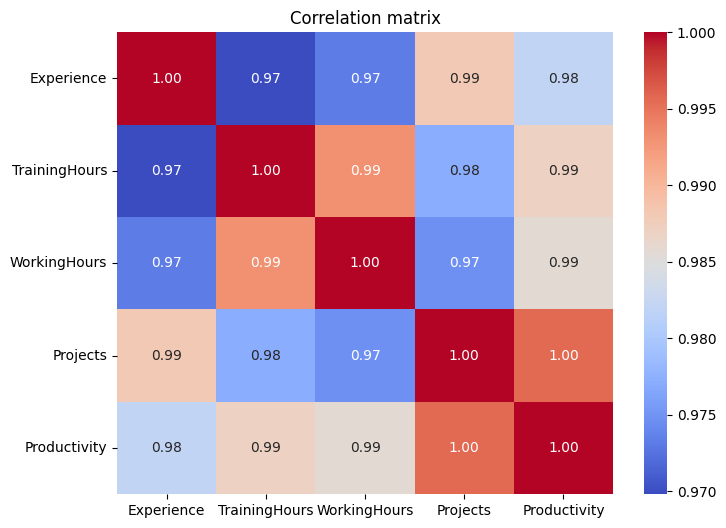

Text(0.5, 1.02, 'Pairplot')

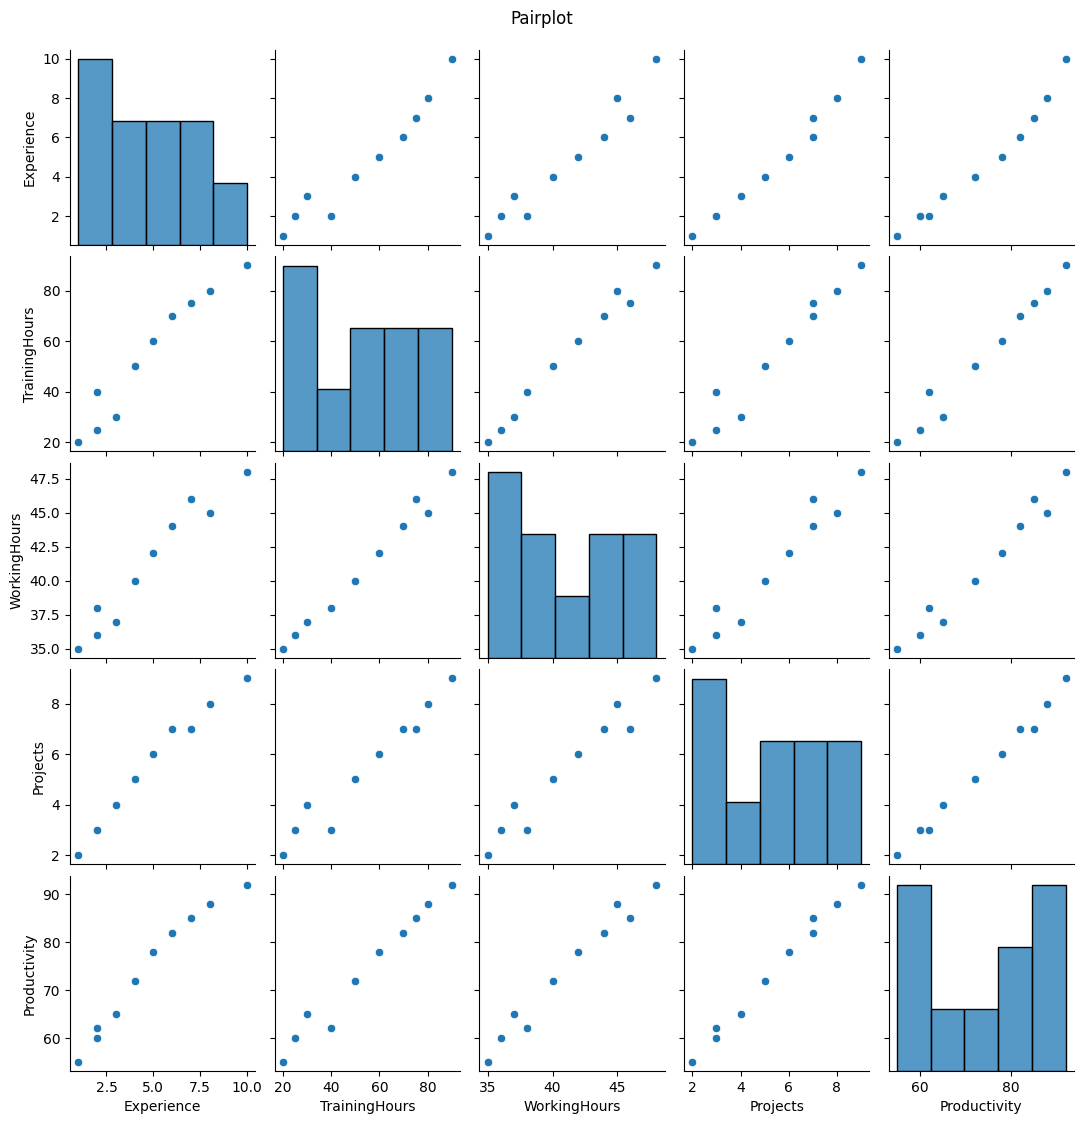

In [4]:
# EDA
print(df_prod.describe().T)
plt.figure(figsize=(8,6))
sns.heatmap(df_prod.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

sns.pairplot(df_prod, vars=['Experience','TrainingHours','WorkingHours','Projects','Productivity'], height=2.2)
plt.suptitle('Pairplot', y=1.02)


In [5]:
# Fit linear regression (OLS)
X = df_prod[['Experience','TrainingHours','WorkingHours','Projects']]
y = df_prod['Productivity']

lr = LinearRegression().fit(X, y)
y_pred = lr.predict(X)

print("Intercept:", lr.intercept_, end="\n\n\n")
coef_df = pd.DataFrame({'feature': X.columns, 'coef': lr.coef_})
coef_df['abs_coef'] = coef_df['coef'].abs()
print(coef_df.sort_values('abs_coef', ascending=False), end="\n\n\n")
print("R^2 (train):", r2_score(y, y_pred))
print("RMSE (train):", np.sqrt(mean_squared_error(y, y_pred)))


Intercept: 17.42533936651573


         feature      coef  abs_coef
3       Projects  4.701357  4.701357
0     Experience -0.963801  0.963801
2   WorkingHours  0.819005  0.819005
1  TrainingHours  0.038009  0.038009


R^2 (train): 0.9972374438067544
RMSE (train): 0.645205078064472


## •	Which factor most strongly impacts productivity?

In [6]:
# Standardized coefficients
scaler = StandardScaler()
X_s = scaler.fit_transform(X)
lr_s = LinearRegression().fit(X_s, y)
coefs_std = pd.DataFrame({'feature': X.columns, 'std_coef': lr_s.coef_})
coefs_std = coefs_std.reindex(coefs_std.std_coef.abs().sort_values(ascending=False).index)
coefs_std


,feature,std_coef
3,Projects,10.554521
2,WorkingHours,3.540715
0,Experience,-2.684839
1,TrainingHours,0.890581


In [7]:
# The feature with the highest absolute standardized coefficient impacts productivity the most
print("Most influential (standardized):", coefs_std.head(1).to_json(orient="records"))

Most influential (standardized): [{"feature":"Projects","std_coef":10.5545213345}]


## •	How does training affect productivity?

In [8]:
training_coef = lr.coef_[X.columns.get_loc("TrainingHours")]
training_coef

0.03800904977375563

In [9]:
print(f"TrainingHours has a positive coefficient {training_coef}, meaning more training slightly increases productivity.")

TrainingHours has a positive coefficient 0.03800904977375563, meaning more training slightly increases productivity.


## •	Should the company increase training hours or working hours?

In [10]:
large_coeff = pd.Series(lr.coef_, index=X.columns)[["TrainingHours","WorkingHours"]].sort_values(ascending=False)

large_coeff

WorkingHours     0.819005
TrainingHours    0.038009
dtype: float64

In [11]:
print(f"{large_coeff.index[0]} has a larger coefficient than {large_coeff.index[1]}, so increasing {large_coeff.index[0]} has a stronger effect")

WorkingHours has a larger coefficient than TrainingHours, so increasing WorkingHours has a stronger effect


## •	What happens if Working Hours increase beyond optimal limits?

In [12]:
df_prod["WorkingHours_sq"] = df_prod["WorkingHours"] ** 2

X_quad = df_prod[["Experience","TrainingHours","WorkingHours","WorkingHours_sq","Projects"]]
quad_model = LinearRegression().fit(X_quad, y)

new_coef = pd.Series(quad_model.coef_, index=X_quad.columns)
new_coef

Experience         1.339554
TrainingHours     -0.088267
WorkingHours       7.966809
WorkingHours_sq   -0.081683
Projects           2.395441
dtype: float64

In [13]:
print(f"the squared term is: {new_coef.WorkingHours_sq},\nProductivity slightly decreases after excessive working hours")

the squared term is: -0.08168304837612379,
Productivity slightly decreases after excessive working hours


## •	Can productivity ever decrease with more experience?

In [14]:
experience_coef = lr.coef_[X.columns.get_loc("Experience")]
experience_coef


-0.9638009049773789

In [15]:
print(f"The coefficient is negative : {experience_coef}, So its inversly corelated to productivity.\nSo productivity decreases with more experience")

The coefficient is negative : -0.9638009049773789, So its inversly corelated to productivity.
So productivity decreases with more experience


## •	How would you detect overfitting in this model?

In [16]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr, X, y, cv=cv, scoring="r2")

train_r2 = lr.score(X, y)
print("Train R2:", train_r2)
print("CV R2 scores:", cv_scores)
print("Mean CV R2:", cv_scores.mean())


Train R2: 0.9972374438067544
CV R2 scores: [0.31460554 0.98150859 0.98148792 0.99858066 0.98438191]
Mean CV R2: 0.8521129219305184


In [17]:
print(f"Overfitting is detected because the training R2 ({train_r2}) is much higher than the mean cross-validation R2 ({cv_scores.mean()}), \nAnd the validation scores vary widely across folds, indicating poor generalization.")

Overfitting is detected because the training R2 (0.9972374438067544) is much higher than the mean cross-validation R2 (0.8521129219305184), 
And the validation scores vary widely across folds, indicating poor generalization.


## •	Suggest one new feature to improve prediction accuracy.

In [18]:
print("Adding a Performance Feedback Score (e.g., an average manager rating from 1–5, where an employee with score 4.5 consistently shows higher productivity than one with 3.0 despite similar hours and projects) \nThis improves prediction accuracy by capturing work quality that quantitative features alone cannot measure.")

Adding a Performance Feedback Score (e.g., an average manager rating from 1–5, where an employee with score 4.5 consistently shows higher productivity than one with 3.0 despite similar hours and projects) 
This improves prediction accuracy by capturing work quality that quantitative features alone cannot measure.


## Interpretations
- **Which factor most strongly impacts productivity?**
- **How does training affect productivity?**
- **Should the company increase training hours or working hours?**
- **What happens if working hours increase beyond optimal limits?**
- **Can productivity ever decrease with more experience?**
- **How would you detect overfitting in this model?**
- **Suggest one new feature to improve prediction accuracy.**

In [19]:
print("1. Most influential (standardized):", coefs_std.head(1).to_json(orient="records"))
print(f"2. TrainingHours has a positive coefficient {training_coef}, meaning more training slightly increases productivity.")
print(f"3. {large_coeff.index[0]} has a larger coefficient than {large_coeff.index[1]}, so increasing {large_coeff.index[0]} has a stronger effect")
print(f"4. the squared term becomes negative: {new_coef.WorkingHours_sq},Productivity eventually decreases after excessive working hours")
print(f"5. The coefficient is negative : {experience_coef}, So its inversly corelated to productivity.So productivity decreases with more experience")
print(f"6. Overfitting is detected because the training R2 ({train_r2}) is much higher than the mean cross-validation R2 ({cv_scores.mean()}), And the validation scores vary widely across folds, indicating poor generalization.")
print("7. Adding a Performance Feedback Score (e.g., an average manager rating from 1–5, where an employee with score 4.5 consistently shows higher productivity than one with 3.0 despite similar hours and projects) This improves prediction accuracy by capturing work quality that quantitative features alone cannot measure.")


1. Most influential (standardized): [{"feature":"Projects","std_coef":10.5545213345}]
2. TrainingHours has a positive coefficient 0.03800904977375563, meaning more training slightly increases productivity.
3. WorkingHours has a larger coefficient than TrainingHours, so increasing WorkingHours has a stronger effect
4. the squared term becomes negative: -0.08168304837612379,Productivity eventually decreases after excessive working hours
5. The coefficient is negative : -0.9638009049773789, So its inversly corelated to productivity.So productivity decreases with more experience
6. Overfitting is detected because the training R2 (0.9972374438067544) is much higher than the mean cross-validation R2 (0.8521129219305184), And the validation scores vary widely across folds, indicating poor generalization.
7. Adding a Performance Feedback Score (e.g., an average manager rating from 1–5, where an employee with score 4.5 consistently shows higher productivity than one with 3.0 despite similar hou